In [1]:
import numpy as np
from tqdm import tqdm
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
def generate_adj_matrix(n, p, q): 
  """
  return adj_matrix
  adj_matrix[i][j]: represents the edge value between the i-th point and the j-th point
  """

  sub_size = int(n/2)

  # construct four subparts of the adjacency matrix separately
  sub_1_inner_adj = np.random.choice([1,0], size=(sub_size,sub_size), p=[p,1-p])
  sub_1_sub_2_inter_adj = np.random.choice([1,0], size=(sub_size,sub_size), p=[q, 1-q])
  sub_2_sub_1_inter_adj = sub_1_sub_2_inter_adj.T
  sub_2_inner_adj = np.random.choice([1,0], size=(sub_size,sub_size), p=[p,1-p])

  # combine four subparts of the adjacency matrix to constrcut adjacency matrix
  sub_1_adj = np.concatenate([sub_1_inner_adj,sub_1_sub_2_inter_adj], axis=1)
  sub_2_adj = np.concatenate([sub_2_sub_1_inter_adj,sub_2_inner_adj], axis=1)
  adj_matrix = np.concatenate([sub_1_adj,sub_2_adj], axis=0)

  for diag_element_index in range(n):
    adj_matrix[diag_element_index][diag_element_index]=0

  return adj_matrix

In [3]:
n = 1000
K = 100

def generate_K_instances(s):
  """
  return K_instances_lst
  K_instances_lst[i]: (the ith generated adj_matrix, 
                       the corresponding nodes_adj_sum)
  """
  
  p = (12+s) / n
  q = (8-s) / n

  K_instances_lst = []
  for i in tqdm(range(K)):
    adj_matrix = generate_adj_matrix(n, p, q)
    nodes_adj_sum = adj_matrix.sum(axis=1)
    K_instances_lst.append((adj_matrix, nodes_adj_sum))

  return K_instances_lst

In [4]:
def generate_instances_dict():
    """
    return instances_dict
    instances_dict[s]: K_instances_lst configured by s
    """

    s_lst = list(range(1,6))
    instances_dict = {}

    for s in s_lst:
      K_instances_lst = generate_K_instances(s)
      instances_dict[s] = K_instances_lst

    return instances_dict

In [6]:
train_dict = generate_instances_dict()

100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

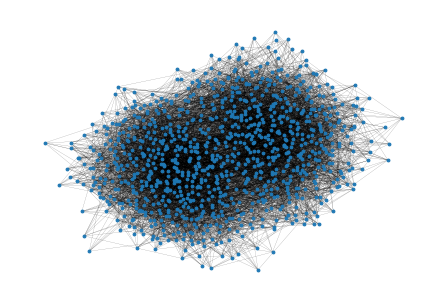

 20%|██        | 1/5 [00:07<00:31,  7.77s/it]

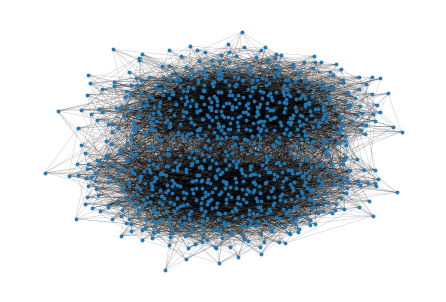

 40%|████      | 2/5 [00:15<00:23,  7.78s/it]

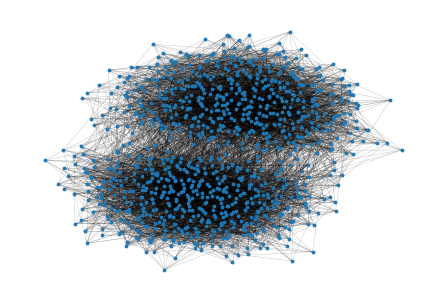

 60%|██████    | 3/5 [00:23<00:15,  7.77s/it]

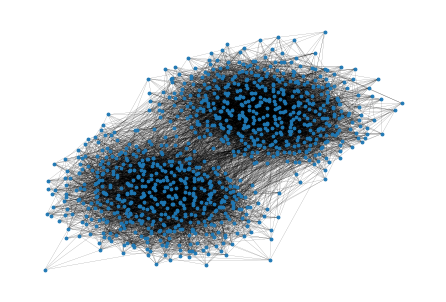

 80%|████████  | 4/5 [00:31<00:07,  7.76s/it]

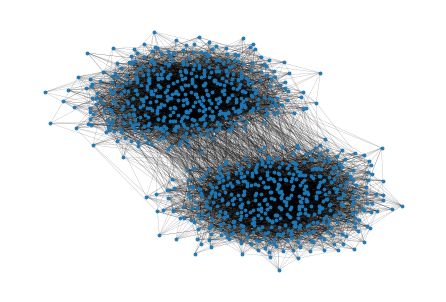

100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


In [7]:
for s_key in tqdm(train_dict.keys()):
  s_value = train_dict.get(s_key)
  graph = nx.convert_matrix.from_numpy_matrix(s_value[np.random.choice(range(K))][0])
  
  nx.draw(graph, node_size=8, width=0.1, pos=nx.spring_layout(graph))
  plt.show()

In [ ]:
### Architecture 1-2.6
import math 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')


class DataSet(Dataset):
  def __init__(self, data_lst):
    self.data_lst = data_lst


  def __len__(self):
    return len(self.data_lst)


  def __getitem__(self, index):
    adj_matrix = self.data_lst[index][0]
    nodes_adj_sum =self.data_lst[index][1]

    # randomly shuffle to initialize
    num_nodes = nodes_adj_sum.shape[0]
    rand_indices = np.random.choice(list(range(num_nodes)), num_nodes, False)
    adj_matrix = adj_matrix[rand_indices]
    nodes_adj_sum = nodes_adj_sum[rand_indices]

    sub_size = int(adj_matrix.shape[0]/2)
    labels = np.concatenate([np.ones((sub_size, 1)), 
                             -np.ones((sub_size, 1))], axis=0).reshape((sub_size*2,1))

    return adj_matrix, nodes_adj_sum, labels


class GCN_layers(torch.nn.Module):
    def __init__(self, last_layer=False):
        super().__init__()
        self.relu=nn.ReLU()

        self.linear_skip = Parameter(torch.FloatTensor(1000, 1))
        self.linear = Parameter(torch.FloatTensor(1000, 1))

        self.instnorm = nn.InstanceNorm1d(1)
        self.last_layer = last_layer
        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.linear_skip.size(1))
        self.linear_skip.data.uniform_(-stdv, stdv)

        stdv = 1. / math.sqrt(self.linear.size(1))
        self.linear.data.uniform_(-stdv, stdv)


    def forward(self, data):
        adj_matrix, nodes_adj_sum = data
        
        skip = self.linear_skip * nodes_adj_sum
        diffused = self.linear * torch.bmm(adj_matrix, nodes_adj_sum)
        
        if self.last_layer: 
          out = self.relu(skip + diffused)
        else:
          out = skip + diffused 
        
        nodes_adj_sum = self.instnorm(out.transpose(1,2)).transpose(1,2)
        return (adj_matrix, nodes_adj_sum)
    
    
    def checknan(self, tensor):
        print(tensor[torch.isnan(tensor)])
        return tensor[torch.isnan(tensor)].shape[0]!=0



class GCN_architecture(torch.nn.Module):
    def __init__(self, depth):
        super().__init__()
        self.depth = depth
        self.gcn_model = nn.Sequential(*[GCN_layers() for k in range(depth)])
        self.last_layer = GCN_layers(last_layer=True)


    def forward(self, adj_matrix, node_adj_sum):
        data = (adj_matrix, node_adj_sum)
        if self.depth == 1: 
          return self.last_layer(data)
        else: 
          out = self.gcn_model(data)
          return self.last_layer(out)


def calculate_basic_logi_loss(out, label):
    loss = torch.mean(torch.log(1+torch.exp(-out*label)), dim=1)

    return loss


def calculate_modified_logi_loss(out, label):
    loss = torch.cat([calculate_basic_logi_loss(out,label), 
                      calculate_basic_logi_loss(out, -label)], dim=1)
    min_loss, indices = torch.min(loss, dim=1)
    loss = torch.mean(min_loss)

    return loss


def calculate_avg_overlap(out, label):
    pred = (out>0).int()
    pred[pred==0] = -1
    sign_sum_1 = torch.sum((pred==label).int())
    sign_sum_2 = torch.sum((pred==-label).int())
    overalp = 2 * (1/(out.shape[0]*out.shape[1]) * (torch.max(sign_sum_1, sign_sum_2).item()) - 1/2)
    
    return overalp


def calculate_avg_overlap_on_testset(model, test_dataloader, device):
  for data in test_dataloader:
    adj_matrix, node_adj_sum, label = data
    adj_matrix, out = model(adj_matrix.float().to(device), 
                            node_adj_sum.unsqueeze(2).float().to(device))
    overlap = calculate_avg_overlap(out, label.to(device))

  return overlap


def calculate_SNR(s):
    a = 12+s
    b = 8-s
    snr = (a-b)**2/(2*(a+b))
    
    return snr 

  
def train_model(s, train_dict, test_dict, verbose=True): 

    train = DataSet(train_dict[s])
    test = DataSet(test_dict[s])

    train_dataloader = DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
    test_dataloader = DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

    model = GCN_architecture(depth=20).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    n_epoch = 50
    for epoch in tqdm(range(n_epoch)): 
        for data in train_dataloader:
            optimizer.zero_grad()

            adj_matrix, node_adj_sum, label = data
            adj_matrix, out = model(adj_matrix.float().to(device), 
                                    node_adj_sum.unsqueeze(2).float().to(device))
            
            loss = calculate_modified_logi_loss(out, 
                                                label.float().to(device))
            loss.backward()
            optimizer.step()

        if verbose:
            with torch.no_grad():
                if epoch%10==0: 
                    train_loss = loss.item()
                    train_overlap = calculate_avg_overlap(out, label.to(device))
                    test_overlap = calculate_avg_overlap_on_testset(model, 
                                                                    test_dataloader, 
                                                                    device)
                    print(f'Using Dataset (s={s}); Epoch: {epoch}; \n \
                            Training loss: {train_loss}; \n \
                            Training Overlap: {train_overlap}; \n \
                            Test Overlap: {test_overlap}')   
                
    snr = calculate_SNR(s)
    print(f'The SNR is {snr}; \n \
            the test overlap is {test_overlap}.')
    return snr, test_overlap

test_dict = generate_instances_dict()
snr_lst = []
test_overlap_lst = []

for s in list(range(1,6)):
    snr, test_overlap = train_model(s, train_dict, test_dict)
    snr_lst.append(snr)
    test_overlap_lst.append(test_overlap)
    
plt.plot(snr_lst, test_overlap_lst);
plt.xlabel(xlabel='SNR')
plt.ylabel(ylabel='Average Overlap')


test_dict = generate_instances_dict()
snr_lst = []
test_overlap_lst = []

for s in list(range(1,6)):
    snr, test_overlap = train_model(s, train_dict, test_dict)
    snr_lst.append(snr)
    test_overlap_lst.append(test_overlap)


### Architecture 1-2.7 
import numpy as np
from numpy import linalg as LA

n = 1000
subset_size = int(n/2)

label = np.concatenate([np.ones((subset_size,1)), np.zeros((subset_size,1))])
label[label==0] = -1


def calculate_avg_overlap_(pred, label): 

    sign_sum_1 = np.sum(pred.reshape((-1,1))==label)
    sign_sum_2 = np.sum(pred.reshape((-1,1))==-label)
    out = 2*(1/(pred.shape[0]) * max(sign_sum_1, sign_sum_2) - 1/2) 

    return out


def spectral_clustering_prediction(adj_matrix):

    eig_val, eig_vec = LA.eig(adj_matrix)

    second_largest_index = np.argsort(eig_val)[-2]
    fiedler_vec = eig_vec[:, second_largest_index]
    pred = np.sign(fiedler_vec)

    return pred


def calculate_avg_overlap_on_testset_(s, test_dict, verbose=True):

    snr = calculate_SNR(s)

    test_data = test_dict[s]
    overlap_lst = []
    i = 1
    
    for data in tqdm(test_data):
        adj_matrix, node_adj_sum = data
        pred = spectral_clustering_prediction(adj_matrix)
        overlap = calculate_avg_overlap_(pred, label)
        overlap_lst.append(overlap)
        if verbose:
            if i%10 == 0:
                print(f'The overlap on the {i}th sample is {overlap}')
        i += 1

    overlap_mean = np.mean(overlap_lst)
    return snr, overlap_mean


s_lst = list(range(1, 6))
snr_lst_ = []
test_overlap_lst_ = []


for i in s_lst:
  snr_, test_overlap_ = calculate_avg_overlap_on_testset_(s=i, test_dict=test_dict)
  snr_lst_.append(snr_)
  test_overlap_lst_.append(test_overlap_)


plt.plot(snr_lst_, test_overlap_lst_, label='Spectral Clustering Prediction');
plt.xlabel(xlabel='SNR')
plt.ylabel(ylabel='Average Overlap')

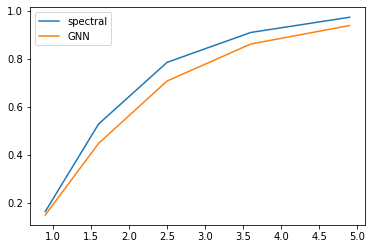

In [ ]:
### Architecture 2-2.6
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

class GNN(nn.Module):

    def __init__(self,l=10):
        super().__init__()
        self.a = nn.ParameterList([nn.Parameter(torch.randn(1)) for i in range(l)])
        self.b = nn.ParameterList([nn.Parameter(torch.randn(1)) for i in range(l)])
        self.l = l

    def forward(self, A):
        x = torch.sum(A, dim=0).view(-1,1)
        for i in range(self.l):
            x = (x-torch.mean(x)) / torch.std(x)
            x = F.relu(self.a[i] * x + self.b[i] * torch.matmul(A, x))
        return x

def criterion(yhat, y):
    """calculate logistic loss"""
    return torch.mean(torch.log(1+torch.exp(-yhat*y)))

def overlap(yhat,y):
    """calculate the overlap between 
        two sets of labels""" 
    ysign = 2.0*(yhat>0)-1.0
    return 2*(torch.max(torch.mean((ysign==+y)*1.0), 
                        torch.mean((ysign==-y)*1.0))-0.5)
    
# initialize model 
model = GNN(l=100)
optimizer = optim.SGD(model.parameters(), lr=0.0003)

# get availabe device 
available = "cuda:0" if torch.cuda.is_available() else "cpu"
device =  torch.device(available)
mode = model.to(device) 


n = 1000 
K = 100 
num_epochs = 5

# produce target class 
class1 = torch.tensor([+1])
class2 = torch.tensor([-1])
target = torch.cat((class1.repeat(n//2), class2.repeat(n//2)))

# train GCN for num_epochs using SGD 
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for s in range(1,6):
        for i in range(len(data)):
            A = torch.tensor(data[s][i,:,:])
            
            # update model based using (A, target)
            optimizer.zero_grad() 
            output = model(A).view(-1)
            loss = torch.min(criterion(output, target), 
                            criterion(output, -target))
            loss.backward()
            optimizer.step() 
            
            if i % 10 == 0: 
                pbar.set_postfix({'loss': loss.item()})
    

# check the overlap 
overlaps = {}
for s in range(1,6):
    # check average overlap 
    total_overlap = 0 
    for i in range(len(data)):
        A = torch.tensor(data[s][i,:,:])
        output = model(A).view(-1)
        total_overlap += overlap(output, target)
    overlaps[s] = total_overlap / len(data)

  
### Architecture 2-2.7
%%time 
from tqdm.notebook import tqdm

# calculate the average spectral overlap for each s 
spectral_overlap = {} 

class1 = torch.tensor([+1])
class2 = torch.tensor([-1])
target = torch.cat((class1.repeat(n//2), class2.repeat(n//2)))

for s in range(1,6):
    
    total_overlap = 0 
    pbar = tqdm(range(K))

    for i in pbar:

        # find the vector with the second highest eigen value 
        vals, vecs = np.linalg.eig(data[s][i,:,:])
        vecs = vecs[:,np.argsort(vals)]
        vals = vals[np.argsort(vals)]
        
        # calculate the overlap using the eigen vector 
        total_overlap += overlap(torch.tensor(vecs[:,-2]), target)
    spectral_overlap[s] = total_overlap / k 


def snr(s):
    """calculate snr from s"""
    a = 12+s
    b = 8-s
    return (a - b)**2/(2*(a + b))

# plot snr against average overlap for each s 
x = [snr(s) for s in spectral_overlap.keys()]
y_spectral = [spectral_overlap[s].numpy().tolist() for s in spectral_overlap.keys()]
y_gnn = [overlaps[s].numpy().tolist() for s in overlaps.keys()]

# plot results
plt.plot(x,y_spectral)
plt.plot(x,y_gnn)
plt.legend(["spectral", "GNN"])
plt.show()